# HLS Multi-Image Download - Time Series & Multiple Areas

Advanced examples for downloading harmonized Landsat-Sentinel (HLS) time series.

**Demonstrates:**
- Time series visualization
- Multiple area processing from GeoJSON
- Comparison of HLS_LANDSAT vs HLS_SENTINEL
- High temporal frequency monitoring

Author: Peter Kongstad

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box, Point

from sat_data_acquisition import SatDataClient, ProcessingParams, configure_logging
from sat_data_acquisition.processing import save_geotiff
from sat_data_acquisition.config.settings import SatDataSettings

In [2]:
# Configure logging
configure_logging(verbose=False)

## Example 1: Compare HLS Sentinel vs HLS Landsat

Download both sources and compare side-by-side for the same area.

In [3]:
# Define area
copenhagen_center = Point(12.5683, 55.6761)
buffer = 0.024

geometry = box(
    copenhagen_center.x - buffer,
    copenhagen_center.y - buffer,
    copenhagen_center.x + buffer,
    copenhagen_center.y + buffer
)

print(f"Area: {geometry.bounds}")

Area: (12.544300000000002, 55.6521, 12.5923, 55.7001)


In [4]:
# Initialize client
client = SatDataClient()
settings = SatDataSettings()

# Download HLS Sentinel
params_sentinel = ProcessingParams(
    satellite='HLS_SENTINEL',
    search_method='geometry',
    start_date='2024-06-01',
    end_date='2024-08-31',
    bands=['B04', 'B03', 'B02'],  # RGB
    cloud_coverage=20,
    sort=True,
    clip_method='geometry'
)

dataset_sentinel = client.search_and_create_image(
    geometry=geometry,
    processing_params=params_sentinel,
    area_name='copenhagen'
)

print(f"[OK] HLS Sentinel: {len(dataset_sentinel.time)} images")

# Download HLS Landsat
params_landsat = ProcessingParams(
    satellite='HLS_LANDSAT',
    search_method='geometry',
    start_date='2024-06-01',
    end_date='2024-08-31',
    bands=['B04', 'B03', 'B02'],  # RGB
    cloud_coverage=20,
    sort=True,
    clip_method='geometry'
)

dataset_landsat = client.search_and_create_image(
    geometry=geometry,
    processing_params=params_landsat,
    area_name='copenhagen'
)

print(f"[OK] HLS Landsat: {len(dataset_landsat.time)} images")

INFO - Found 30 items for HLS_SENTINEL matching the search query.
INFO - Found 17 items for HLS_LANDSAT matching the search query.


[OK] HLS Sentinel: 30 images
[OK] HLS Landsat: 17 images


## Visualization Helper Functions

Process RGB bands with percentile stretching for natural-looking images.

In [5]:
def process_rgb_for_display(image_slice, gamma=0.9):
    """
    Process RGB bands for display with percentile stretching.
    
    Args:
        image_slice: xarray Dataset with B04, B03, B02 bands
        gamma: Gamma correction value (default 0.9)
        
    Returns:
        RGB array (H, W, 3) with values in [0, 1]
    """
    # Stack RGB bands
    rgb = np.dstack([
        image_slice['B04'].values,
        image_slice['B03'].values,
        image_slice['B02'].values
    ])
    
    # Get valid pixels
    valid_pixels = rgb[rgb > 0]
    
    if len(valid_pixels) == 0:
        return np.zeros_like(rgb)
    
    # Percentile stretching (2nd-98th percentile)
    p2, p98 = np.percentile(valid_pixels, [2, 98])
    rgb_stretched = np.clip((rgb - p2) / (p98 - p2), 0, 1)
    
    # Gamma correction
    rgb_corrected = np.power(rgb_stretched, gamma)
    
    return rgb_corrected

## Compare Side-by-Side

Show up to 3 images from each source (6 total images).

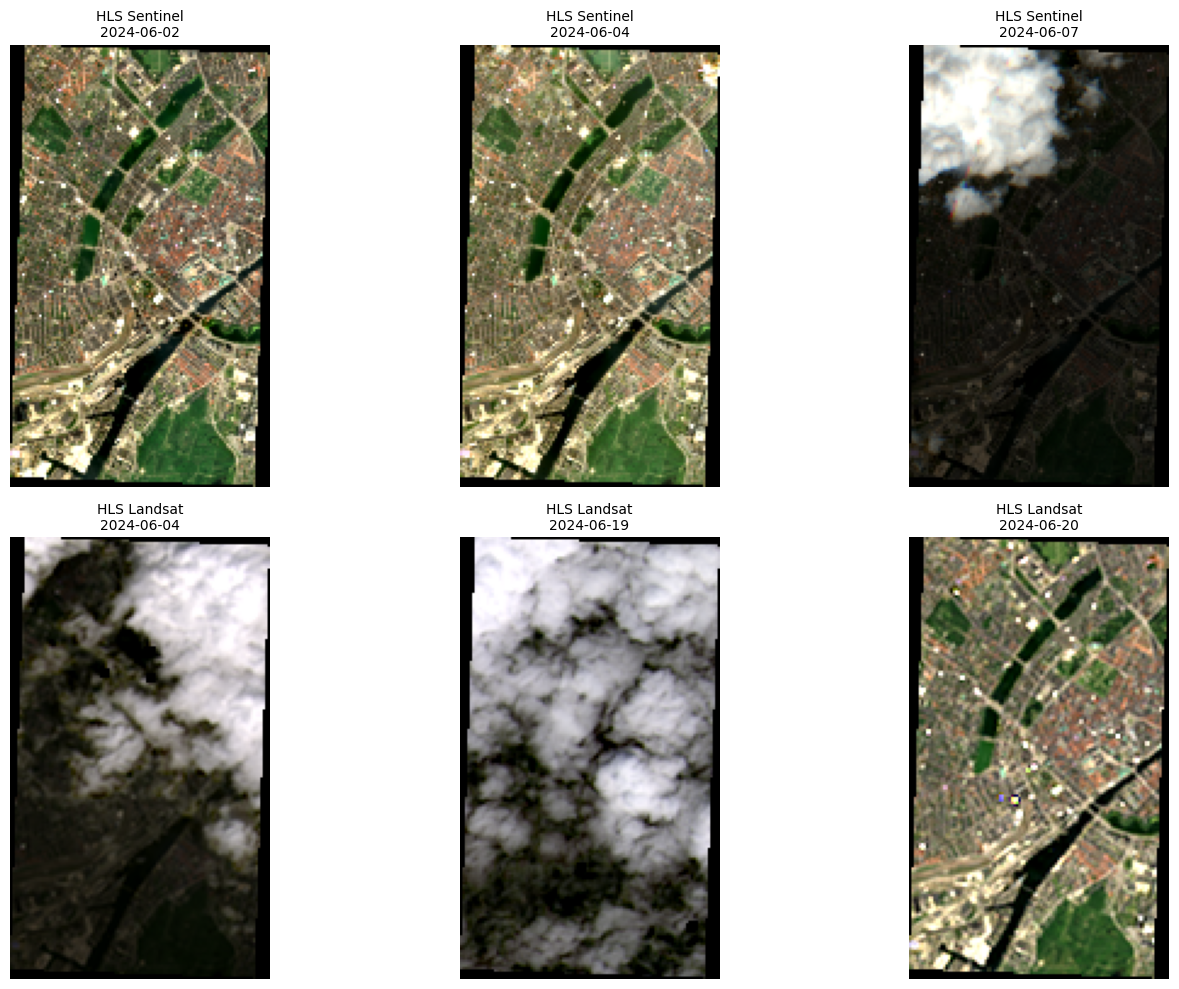


Comparison saved as: hls_comparison.png
HLS Sentinel: 30 images
HLS Landsat: 17 images


In [6]:
# Compare both sources with up to 3 images each
n_display = 3
rows = 2  # Top row: HLS Sentinel, Bottom row: HLS Landsat
cols = n_display

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Top row: HLS Sentinel
n_sentinel = min(len(dataset_sentinel.time), n_display)
for idx in range(cols):
    ax = axes[0, idx]
    
    if idx < n_sentinel:
        time_val = dataset_sentinel.time.values[idx]
        image_slice = dataset_sentinel.sel(time=time_val)
        rgb = process_rgb_for_display(image_slice)
        date_str = str(time_val)[:10]
        
        ax.imshow(rgb)
        ax.set_title(f'HLS Sentinel\n{date_str}', fontsize=10)
        ax.axis('off')
    else:
        ax.axis('off')

# Bottom row: HLS Landsat
n_landsat = min(len(dataset_landsat.time), n_display)
for idx in range(cols):
    ax = axes[1, idx]
    
    if idx < n_landsat:
        time_val = dataset_landsat.time.values[idx]
        image_slice = dataset_landsat.sel(time=time_val)
        rgb = process_rgb_for_display(image_slice)
        date_str = str(time_val)[:10]
        
        ax.imshow(rgb)
        ax.set_title(f'HLS Landsat\n{date_str}', fontsize=10)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.savefig('hls_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nComparison saved as: hls_comparison.png")
print(f"HLS Sentinel: {len(dataset_sentinel.time)} images")
print(f"HLS Landsat: {len(dataset_landsat.time)} images")

## Example 2: Multiple Areas with Both Sources

Download and compare both HLS sources for multiple areas.

In [7]:
# Load GeoJSON with multiple areas
gdf = gpd.read_file('../../data/geojson/example_areas.geojson')

print(f"[OK] Loaded {len(gdf)} areas")
print(gdf[['name', 'description']])

[OK] Loaded 3 areas
         name                           description
0  copenhagen     Copenhagen, Denmark - City Center
1      london  London, United Kingdom - Westminster
2     seattle               Seattle, USA - Downtown


In [8]:
# Process images for each area with both sources
results = []

for _, row in gdf.iterrows():
    area_name = row['name']
    geometry = row.geometry
    
    # Try HLS Sentinel
    try:
        dataset_s = client.search_and_create_image(
            geometry=geometry,
            processing_params=params_sentinel,
            area_name=area_name,
        )
        n_sentinel = len(dataset_s.time)
        print(f"[OK] {area_name} - HLS Sentinel: {n_sentinel} images")
    except Exception as e:
        n_sentinel = 0
        print(f"[WARN] {area_name} - HLS Sentinel failed")
    
    # Try HLS Landsat
    try:
        dataset_l = client.search_and_create_image(
            geometry=geometry,
            processing_params=params_landsat,
            area_name=area_name,
        )
        n_landsat = len(dataset_l.time)
        print(f"[OK] {area_name} - HLS Landsat: {n_landsat} images")
    except Exception as e:
        n_landsat = 0
        print(f"[WARN] {area_name} - HLS Landsat failed")
    
    results.append({
        'area': area_name,
        'hls_sentinel': n_sentinel,
        'hls_landsat': n_landsat,
        'total': n_sentinel + n_landsat
    })

print(f"\n[OK] Processed {len(results)} areas")

INFO - Found 30 items for HLS_SENTINEL matching the search query.
INFO - Found 17 items for HLS_LANDSAT matching the search query.


[OK] copenhagen - HLS Sentinel: 30 images
[OK] copenhagen - HLS Landsat: 17 images


INFO - Found 66 items for HLS_SENTINEL matching the search query.


[OK] london - HLS Sentinel: 36 images


INFO - Found 28 items for HLS_LANDSAT matching the search query.


[OK] london - HLS Landsat: 14 images


INFO - Found 34 items for HLS_SENTINEL matching the search query.


[OK] seattle - HLS Sentinel: 34 images


INFO - Found 22 items for HLS_LANDSAT matching the search query.


[OK] seattle - HLS Landsat: 22 images

[OK] Processed 3 areas


INFO - Found 30 items for HLS_SENTINEL matching the search query.
INFO - Found 17 items for HLS_LANDSAT matching the search query.
INFO - Found 66 items for HLS_SENTINEL matching the search query.
INFO - Found 28 items for HLS_LANDSAT matching the search query.
INFO - Found 34 items for HLS_SENTINEL matching the search query.
INFO - Found 22 items for HLS_LANDSAT matching the search query.


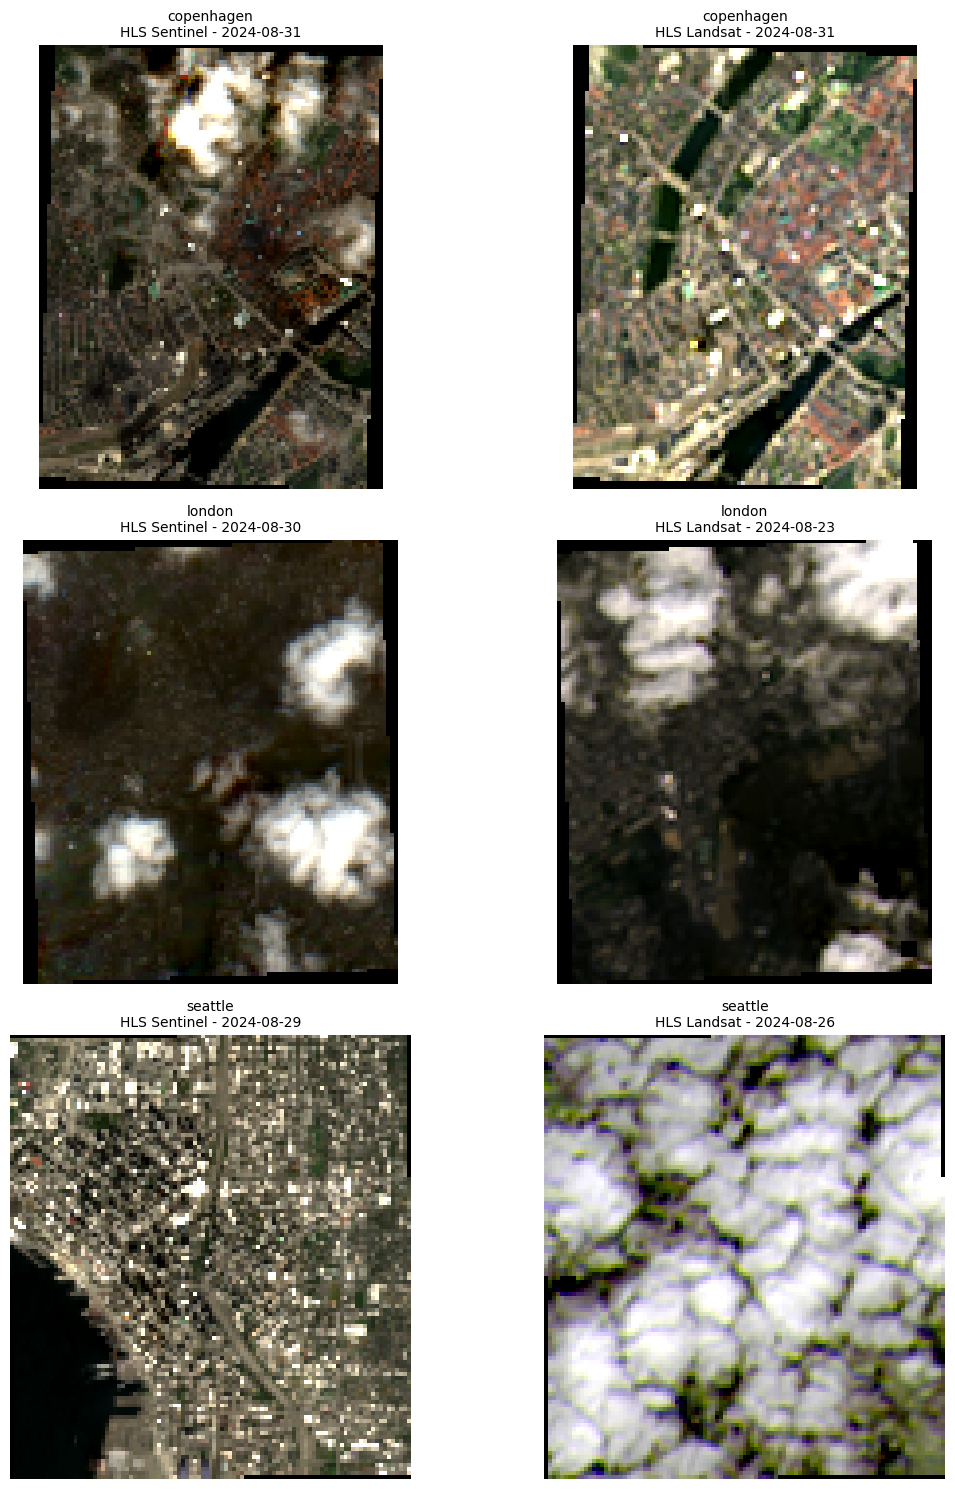


Visualization saved as: hls_multi_area_comparison.png


In [9]:
# Visualize both sources for each area (side-by-side)
max_areas = min(len(gdf), 3)
rows = max_areas
cols = 2  # Left: HLS Sentinel, Right: HLS Landsat

fig, axes = plt.subplots(rows, cols, figsize=(12, 5*rows))
if rows == 1:
    axes = axes.reshape(1, -1)

for area_idx, (_, row) in enumerate(gdf.iterrows()):
    if area_idx >= max_areas:
        break
    
    area_name = row['name']
    geometry = row.geometry
    
    # HLS Sentinel (left column)
    try:
        dataset_s = client.search_and_create_image(
            geometry=geometry,
            processing_params=params_sentinel,
            area_name=area_name,
        )
        
        if len(dataset_s.time) > 0:
            image_slice = dataset_s.sel(time=dataset_s.time.values[-1])
            date_str = str(dataset_s.time.values[-1])[:10]
            rgb = process_rgb_for_display(image_slice)
            
            axes[area_idx, 0].imshow(rgb, aspect='equal')
            axes[area_idx, 0].set_title(f'{area_name}\nHLS Sentinel - {date_str}', fontsize=10)
            axes[area_idx, 0].axis('off')
        else:
            axes[area_idx, 0].axis('off')
            axes[area_idx, 0].text(0.5, 0.5, f'{area_name}\nNo HLS Sentinel', 
                                  ha='center', va='center', transform=axes[area_idx, 0].transAxes)
    except Exception as e:
        axes[area_idx, 0].axis('off')
        axes[area_idx, 0].text(0.5, 0.5, f'{area_name}\nError', 
                              ha='center', va='center', transform=axes[area_idx, 0].transAxes)
    
    # HLS Landsat (right column)
    try:
        dataset_l = client.search_and_create_image(
            geometry=geometry,
            processing_params=params_landsat,
            area_name=area_name,
        )
        
        if len(dataset_l.time) > 0:
            image_slice = dataset_l.sel(time=dataset_l.time.values[-1])
            date_str = str(dataset_l.time.values[-1])[:10]
            rgb = process_rgb_for_display(image_slice)
            
            axes[area_idx, 1].imshow(rgb, aspect='equal')
            axes[area_idx, 1].set_title(f'{area_name}\nHLS Landsat - {date_str}', fontsize=10)
            axes[area_idx, 1].axis('off')
        else:
            axes[area_idx, 1].axis('off')
            axes[area_idx, 1].text(0.5, 0.5, f'{area_name}\nNo HLS Landsat', 
                                  ha='center', va='center', transform=axes[area_idx, 1].transAxes)
    except Exception as e:
        axes[area_idx, 1].axis('off')
        axes[area_idx, 1].text(0.5, 0.5, f'{area_name}\nError', 
                              ha='center', va='center', transform=axes[area_idx, 1].transAxes)

plt.tight_layout()
plt.savefig('hls_multi_area_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved as: hls_multi_area_comparison.png")

In [10]:
# Summary
import pandas as pd
df = pd.DataFrame(results)
print("\nProcessing Summary:")
print(df)


Processing Summary:
         area  hls_sentinel  hls_landsat  total
0  copenhagen            30           17     47
1      london            36           14     50
2     seattle            34           22     56


## Save Images to Disk

Save all downloaded images as GeoTIFF files.

In [11]:
# Save images from both sources for first area
if len(gdf) > 0:
    area_row = gdf.iloc[0]
    area_name = area_row['name']
    geometry = area_row.geometry
    
    # Save HLS Sentinel images
    try:
        dataset_s = client.search_and_create_image(
            geometry=geometry,
            processing_params=params_sentinel,
            area_name=area_name,
        )
        
        print(f"\nSaving HLS Sentinel images for {area_name}...")
        for time_val in dataset_s.time.values:
            image_slice = dataset_s.sel(time=time_val)
            date_str = str(time_val)[:10]
            
            save_geotiff(
                image=image_slice,
                identifier=area_name.lower(),
                datetime=date_str,
                satellite=params_sentinel.satellite,
                provider='MPC',
                output_path='../../data/images',
                save_to_local=True,
                identifier_type='area_name',
                enable_compression=True,
                settings=settings,
            )
        print(f"  ✓ Saved {len(dataset_s.time)} HLS Sentinel images")
    except Exception as e:
        print(f"  ✗ Failed to save HLS Sentinel: {e}")
    
    # Save HLS Landsat images
    try:
        dataset_l = client.search_and_create_image(
            geometry=geometry,
            processing_params=params_landsat,
            area_name=area_name,
        )
        
        print(f"\nSaving HLS Landsat images for {area_name}...")
        for time_val in dataset_l.time.values:
            image_slice = dataset_l.sel(time=time_val)
            date_str = str(time_val)[:10]
            
            save_geotiff(
                image=image_slice,
                identifier=area_name.lower(),
                datetime=date_str,
                satellite=params_landsat.satellite,
                provider='MPC',
                output_path='../../data/images',
                save_to_local=True,
                identifier_type='area_name',
                enable_compression=True,
                settings=settings,
            )
        print(f"  ✓ Saved {len(dataset_l.time)} HLS Landsat images")
    except Exception as e:
        print(f"  ✗ Failed to save HLS Landsat: {e}")
    
    print("\n✓ Saving complete!")

INFO - Found 30 items for HLS_SENTINEL matching the search query.



Saving HLS Sentinel images for copenhagen...
  ✓ Saved 30 HLS Sentinel images


INFO - Found 17 items for HLS_LANDSAT matching the search query.



Saving HLS Landsat images for copenhagen...
  ✓ Saved 17 HLS Landsat images

✓ Saving complete!


## HLS Key Advantages

### Combining Both Sources

For maximum temporal coverage, combine HLS_LANDSAT and HLS_SENTINEL:

```python
import xarray

# Combine datasets
combined = xarray.concat([dataset_sentinel, dataset_landsat], dim='time')
combined = combined.sortby('time')

# Result: ~3 day effective revisit time
print(f"Combined: {len(combined.time)} images")
```

### Temporal Frequency Comparison

- **HLS Sentinel alone**: ~5 days revisit
- **HLS Landsat alone**: ~16 days revisit  
- **Combined**: ~3 days effective revisit time

### Use Cases

- **Agriculture**: High-frequency crop monitoring during growing season
- **Rapid change detection**: More observations = better change detection
- **Gap-filling**: Reduce cloud impacts with more acquisition opportunities
- **Time series analysis**: Denser temporal sampling for trend detection

### Quality Assurance

Both HLS products include a QA band (B12) for quality filtering:

```python
# Access QA band
qa = dataset['B12'].values
# Use bit flags for cloud masking and quality filtering
```